In [1]:
from pragmaticquant import market

mkt_datas = market.MarketDatas.load_json('mkt.json')
mkt = market.Market(mkt_datas)
print('Market RefDate = %s' % mkt.refdate())

Market RefDate = 2015-04-29 00:00:00


In [2]:
from dateutil.relativedelta import relativedelta
from pragmaticquant import model
from pragmaticquant.pricing import PricingConfig, MonteCarloAlgo

stoch_vol = model.stochvol_params(k1=5.30, k2=0.3, nu=1.90, rho_sx=-0.58, rho_sy=-0.5, rho_xy=0.2774, theta=0.2171)
lsv_model = model.mixedlv_bergomi_model('SP500', 
                                            divmodel = {"0d" : 0.0, "3m" : 0.25, "1y" : 0.75, "10y" : 1.0}, 
                                            stochvol_params=stoch_vol, )

lsv_config = PricingConfig(algorithm = MonteCarloAlgo(50000, nbsteps=200),
                           model = lsv_model, 
                           market = mkt_datas)

In [3]:
from pragmaticquant.pricing import get_equitysmile_viewer_task
mats = ['3m', '6m', '1y', '2y', '5y']
spot = mkt.assetspot('SP500')
strikes = [spot * m for m in [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]]
viewer = get_equitysmile_viewer_task('SP500', mats, strikes)
%time lsv_smile = viewer(lsv_config)

Wall time: 16 s


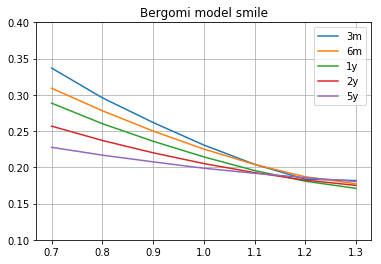

In [4]:
from pandas import DataFrame
import numpy as np

%matplotlib inline
lsv_df = DataFrame(data=np.array(lsv_smile).transpose(), columns=mats, index=strikes)
lsv_df.plot(ylim=(0.1, 0.4), grid=True, title='Bergomi model smile')

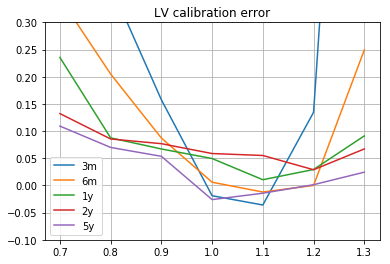

In [5]:
mkt_smile = np.array(mkt.assetvol('SP500', mats, strikes))
error = (np.array(lsv_smile) - mkt_smile) * 100
DataFrame(data=error.transpose(), columns=mats, index=strikes
         ).plot(grid=True, title='LV calibration error', ylim=(-0.1, 0.3))